## **Import Some Basic Libraries**

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# For example, here's several helpful packages to load

import tensorflow as tf
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import copy as cp
import cv2

# Visualizations's libs
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

# Modeling used libs
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import OneHotEncoder 
onehotencoder = OneHotEncoder()

from keras.models import Model,Sequential, Input, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, Lambda, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from keras import backend as K

#from keras.applications import DenseNet121

# Avoid warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/wafersdata/df_wafers.csv
/kaggle/input/wafersdata/df_wafers_head.csv
/kaggle/input/wafersdata/df_wafers_test.csv
/kaggle/input/wafersdata/df_wafers_test_head.csv


## **Reading the Training Data and understanding the attributes**

In [2]:
# reading the training data
training_data = pd.read_csv('../input/wafersdata/df_wafers.csv')
training_df = pd.DataFrame(training_data)

#readiing the testing data
testing_data = pd.read_csv('../input/wafersdata/df_wafers_test.csv')
testing_df = pd.DataFrame(testing_data)

# getting the shape of the training data
# we have 16772092 rows (including duplicates) and 5 columns
print(training_data.shape[0]," rows of wafers' trainng data and ",training_data.shape[1], "columns")

# Show the training data's columns' names
print("The training data's columns' names: ", training_df.columns.values)

# we have 3920 wafers' data in our training data
print((training_df["WaferName"].unique()).shape[0]," wafers' data in our training data")

# getting the shape of the testing data
# we have 1860063 rows (including duplicates) and 4 columns
print(testing_data.shape[0]," rows of wafers' testing data and ",testing_data.shape[1], "columns")

# Show the testing data's columns' names
print("The testing data's columns' names: ", testing_df.columns.values)

# we have 439 wafers' data in our testing data
print((testing_df["WaferName"].unique()).shape[0]," wafers' data in our testing data")

16772092  rows of wafers' trainng data and  5 columns
The training data's columns' names:  ['WaferName' 'DieX' 'DieY' 'IsGoodDie' 'IsScratchDie']
3920  wafers' data in our training data
1860063  rows of wafers' testing data and  4 columns
The testing data's columns' names:  ['WaferName' 'DieX' 'DieY' 'IsGoodDie']
439  wafers' data in our testing data


### Reading the head of the data sets

In [31]:
print("Training Set's Head\n")
training_data.head()

Training Set's Head



,WaferName,DieX,DieY,IsGoodDie,IsScratchDie
0,3b2e28,0,12,False,False
1,3b2e28,0,13,True,False
2,3b2e28,0,14,False,False
3,3b2e28,0,15,True,False
4,3b2e28,0,16,True,False


In [3]:
print("Testing Set's Head\n")
testing_data.head()

Testing Set's Head



,WaferName,DieX,DieY,IsGoodDie
0,5a6ad6,0,12,False
1,5a6ad6,0,13,True
2,5a6ad6,0,14,True
3,5a6ad6,0,15,True
4,5a6ad6,0,16,True


## Check for wafers' dimensions

In [8]:
print("Training set's wafers' dimensions: \n")
training_dim_x = (training_df.groupby(['WaferName'])['DieX'].max()+1).reset_index(name='dimX')
training_dim_y = (training_df.groupby(['WaferName'])['DieY'].max()+1).reset_index(name='dimY')
train_dim = pd.merge(training_dim_x, training_dim_y, on='WaferName')
print(train_dim)
if (train_dim.query("dimX != dimY")).empty:
    print("All the wafers from training data are square")
print("Max and min dims are:",train_dim['dimX'].max(),train_dim['dimX'].min())
print("Most common dim:\n",(train_dim['dimX'].value_counts()).head())
print("Mean dim is: ",(train_dim['dimX'].mean()))
print("\n")

print("Test set's wafers' dimensions:\n")
testdim_x = (testing_df.groupby(['WaferName'])['DieX'].max()+1).reset_index(name='dimX')
testdim_y = (testing_df.groupby(['WaferName'])['DieY'].max()+1).reset_index(name='dimY')
test_dim = pd.merge(testdim_x, testdim_y, on='WaferName')
print(test_dim)
if (test_dim.query("dimX != dimY")).empty:
    print("All the wafers from testing data are square")
print("Max and min dims are:",test_dim['dimX'].max(),test_dim['dimX'].min())
print("Most common dim:\n",(test_dim['dimX'].value_counts()).head())
print("Mean dim is: ",int(test_dim['dimX'].mean()))
MEAN_DIM = int((train_dim['dimX'].mean()+test_dim['dimX'].mean())/2)

Training set's wafers' dimensions: 

     WaferName  dimX  dimY
0       001f23    35    35
1       002e68    85    85
2       002ff9    99    99
3       003483    21    21
4       004531    43    43
...        ...   ...   ...
3915    ffa518    71    71
3916    ffdb12    77    77
3917    ffe0d2    43    43
3918    ffe584   105   105
3919    ffff74    35    35

[3920 rows x 3 columns]
All the wafers from training data are square
Max and min dims are: 105 21
Most common dim:
 85     380
105    374
49     365
77     359
91     357
Name: dimX, dtype: int64
Mean dim is:  68.78877551020408


Test set's wafers' dimensions:

    WaferName  dimX  dimY
0      00ad5c    57    57
1      01913a    35    35
2      02925a    91    91
3      029e8f    43    43
4      02baed    21    21
..        ...   ...   ...
434    ff627d    99    99
435    ff6aae    85    85
436    ff70d1    71    71
437    ff9f36    85    85
438    ffc701    77    77

[439 rows x 3 columns]
All the wafers from testing data are squ

### Check for Null values

In [9]:
# Checking if the dataset contains any NULL values
print(training_data.isnull().any().any(),"\n")
# Checking if the dataset contains any NULL values
print(testing_data.isnull().any().any())

False 

False


## **Summarizing some statistics regarding the wafers**

### **Statistics: Good or Bad dies from training data**

In [10]:
training_df_good_dies = training_df.groupby(['WaferName', 'IsGoodDie']).size().reset_index(name='Count')

filtered_df1 = training_df_good_dies.query('IsGoodDie')
filtered_df1 = filtered_df1.drop(columns='IsGoodDie')
filtered_df1 = filtered_df1.sort_values(by='Count', ascending=False)
filtered_df11 = filtered_df1.reset_index().rename(columns={'Count': 'GoodDiesCount'})

print(filtered_df11.head(),'\n')

filtered_df2 = training_df_good_dies.query('~IsGoodDie')
filtered_df2 = filtered_df2.drop(columns='IsGoodDie')
filtered_df2 = filtered_df2.sort_values(by='Count', ascending=False)
filtered_df22 = filtered_df2.reset_index().rename(columns={'Count': 'BadDiesCount'})
print(filtered_df22.head(),'\n')

organized_filtered_df = pd.merge(filtered_df11, filtered_df22, on='WaferName')
organized_filtered_df = organized_filtered_df.drop(columns=['index_x','index_y'])
organized_filtered_df['BadDiesRatio(%)'] = (organized_filtered_df['BadDiesCount']/(organized_filtered_df['BadDiesCount']+organized_filtered_df['GoodDiesCount'])*100)
organized_filtered_df = organized_filtered_df.sort_values(by='BadDiesRatio(%)', ascending=False)
print(organized_filtered_df.head(),'\n')

   index WaferName  GoodDiesCount
0   6973    e457c9           8590
1    733    193dbe           8583
2   5361    af16a7           8553
3   3993    83f20d           8515
4   6935    e33c8a           8511 

   index WaferName  BadDiesCount
0   2304    4e33e9          2018
1   2286    4d5cb2          1966
2   1732    3903a9          1957
3   1734    390901          1895
4   1850    3e2944          1883 

     WaferName  GoodDiesCount  BadDiesCount  BadDiesRatio(%)
3919    1ca655            255           118        31.635389
3918    9986b3            260           113        30.294906
3917    7d720d            261           112        30.026810
3916    38d14c            263           110        29.490617
3915    2c1ae0            264           109        29.222520 



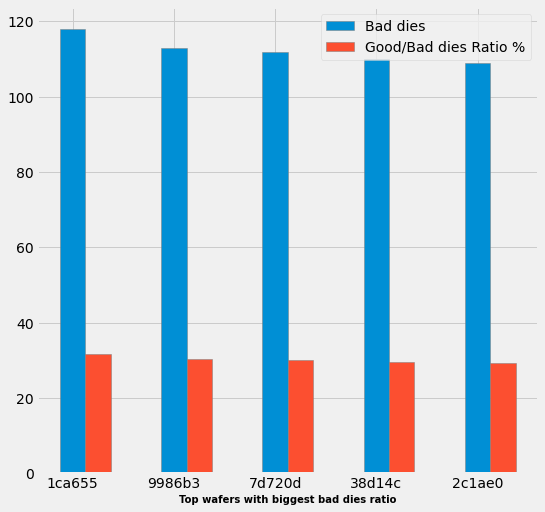

In [14]:
barWidth = 0.25
fig = plt.subplots(figsize =(8, 8))
br1 = np.arange(5)
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
br4 = [x + barWidth for x in br3]
br5 = [x + barWidth for x in br4]
#GD = organized_filtered_df.head()['GoodDiesCount'].values
BD = organized_filtered_df.head()['BadDiesCount'].values
GBDR = organized_filtered_df.head()['BadDiesRatio(%)'].values
GBNAMES = organized_filtered_df.head()['WaferName'].values

#plt.bar(br1, GD, width = barWidth,
#        edgecolor ='grey', label ='Good dies')
plt.bar(br2, BD, width = barWidth,
        edgecolor ='grey', label ='Bad dies')
plt.bar(br3, GBDR, width = barWidth,
        edgecolor ='grey', label ='Good/Bad dies Ratio %')

plt.xlabel('Top wafers with biggest bad dies ratio', fontweight ='bold', fontsize = 10)
plt.ylabel('', fontweight ='bold', fontsize = 10)
plt.xticks([r + barWidth for r in range(5)],GBNAMES)
 
plt.legend()
plt.show()

### **Statistics: Sctrached or none scratched dies from training data**

In [15]:
training_df_sc_dies = training_df.groupby(['WaferName', 'IsScratchDie']).size().reset_index(name='ScratchedDiesCount')

filtered_sc_df1 = training_df_sc_dies.query('IsScratchDie')
filtered_sc_df1 = filtered_sc_df1.drop(columns='IsScratchDie')
filtered_sc_df1 = filtered_sc_df1.sort_values(by='ScratchedDiesCount', ascending=False)
filtered_sc_df11 = filtered_sc_df1.reset_index().rename(columns={'Count': 'ScratchedDiesCount'})

print(filtered_sc_df11.head(),'\n')

filtered_sc_df2 = training_df_sc_dies.query('~IsScratchDie')
filtered_sc_df2 = filtered_sc_df2.drop(columns='IsScratchDie')
filtered_sc_df2 = filtered_sc_df2.sort_values(by='ScratchedDiesCount', ascending=False)
filtered_sc_df22 = filtered_sc_df2.reset_index().rename(columns={'ScratchedDiesCount': 'NoneScratchedDiesCount'})
print(filtered_sc_df22.head(),'\n')

organized_filtered_sc_df = pd.merge(filtered_sc_df11, filtered_sc_df22, on='WaferName')
organized_filtered_sc_df = organized_filtered_sc_df.drop(columns=['index_x','index_y'])
organized_filtered_sc_df['ScratchedDiesRatio(%)'] = (organized_filtered_sc_df['ScratchedDiesCount']/(organized_filtered_sc_df['ScratchedDiesCount']+organized_filtered_sc_df['NoneScratchedDiesCount'])*100)
organized_filtered_sc_df = organized_filtered_sc_df.sort_values(by='ScratchedDiesRatio(%)', ascending=False)
print(organized_filtered_sc_df.head(),'\n')

   index WaferName  ScratchedDiesCount
0   3403    965f13                 166
1   1451    4380f1                 166
2   3336    9352ac                 154
3   2830    7e1079                 144
4   1039    2e501c                 143 

   index WaferName  NoneScratchedDiesCount
0   4023    b1134a                    8797
1   3235    8ee909                    8797
2   2608    75c22f                    8797
3   3192    8da124                    8797
4    500    17849e                    8797 

    WaferName  ScratchedDiesCount  NoneScratchedDiesCount  \
400    e3cab4                  58                     947   
441    e294ed                  56                     949   
485    1bda80                  54                     951   
519    d62f0c                  52                     953   
689    e7741a                  46                     959   

     ScratchedDiesRatio(%)  
400               5.771144  
441               5.572139  
485               5.373134  
519               5.1

### **Statistics: Good or Bad dies from testing data**

In [18]:
testing_df_good_dies = testing_df.groupby(['WaferName', 'IsGoodDie']).size().reset_index(name='Count')

filtered_test_df1 = testing_df_good_dies.query('IsGoodDie')
filtered_test_df1 = filtered_test_df1.drop(columns='IsGoodDie')
filtered_test_df1 = filtered_test_df1.sort_values(by='Count', ascending=False)
filtered_test_df11 = filtered_test_df1.reset_index().rename(columns={'Count': 'GoodDiesCount'})

print(filtered_test_df11.head(),'\n')

filtered_test_df2 = testing_df_good_dies.query('~IsGoodDie')
filtered_test_df2 = filtered_test_df2.drop(columns='IsGoodDie')
filtered_test_df2 = filtered_test_df2.sort_values(by='Count', ascending=False)
filtered_test_df22 = filtered_test_df2.reset_index().rename(columns={'Count': 'BadDiesCount'})
print(filtered_test_df22.head(),'\n')

organized_filtered_test_df = pd.merge(filtered_test_df11, filtered_test_df22, on='WaferName')
organized_filtered_test_df = organized_filtered_test_df.drop(columns=['index_x','index_y'])
organized_filtered_test_df['BadDiesRatio(%)'] = (organized_filtered_test_df['BadDiesCount']/(organized_filtered_test_df['BadDiesCount']+organized_filtered_test_df['GoodDiesCount'])*100)
organized_filtered_test_df = organized_filtered_test_df.sort_values(by='BadDiesRatio(%)', ascending=False)
print(organized_filtered_test_df.head(),'\n')

   index WaferName  GoodDiesCount
0    383    713e20           8596
1    485    97e023           8514
2     75    1a1411           8380
3    167    330713           8329
4    697    cf71da           8321 

   index WaferName  BadDiesCount
0    532    aa2cd3          1874
1    456    8deeb8          1767
2    364    699977          1638
3    590    b7ca04          1631
4    248    4576c8          1576 

    WaferName  GoodDiesCount  BadDiesCount  BadDiesRatio(%)
438    02baed            268           105        28.150134
421    049ed0            751           254        25.273632
381    d2a329           1136           377        24.917383
437    2da14c            285            88        23.592493
380    b0e298           1159           354        23.397224 



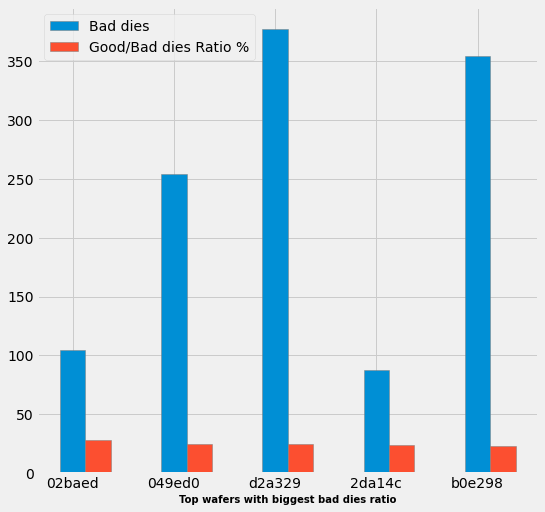

In [19]:
barWidth = 0.25
fig2 = plt.subplots(figsize =(8, 8))
b1 = np.arange(5)
b2 = [x + barWidth for x in b1]
b3 = [x + barWidth for x in b2]
b4 = [x + barWidth for x in b3]
b5 = [x + barWidth for x in b4]
#GD_2 = organized_filtered_test_df.head(5)['GoodDiesCount'].values
BD_2 = organized_filtered_test_df.head()['BadDiesCount'].values
GBDR_2 = organized_filtered_test_df.head()['BadDiesRatio(%)'].values
GBNAMES_2 = organized_filtered_test_df.head()['WaferName'].values

#plt.bar(b1, GD_2, width = barWidth,
#        edgecolor ='grey', label ='Good dies')
plt.bar(b2, BD_2, width = barWidth,
        edgecolor ='grey', label ='Bad dies')
plt.bar(b3, GBDR_2, width = barWidth,
        edgecolor ='grey', label ='Good/Bad dies Ratio %')

plt.xlabel('Top wafers with biggest bad dies ratio', fontweight ='bold', fontsize = 10)
plt.ylabel('', fontweight ='bold', fontsize = 10)
plt.xticks([r + barWidth for r in range(5)],GBNAMES_2)
 
plt.legend()
plt.show()

## **Data Visualization**

### **Transforming Images**

In [40]:
TRAIN_FLAG = 0
TEST_FLAG = 1
NONESCRATCH = 0
SCRATCH = 1
class Data_Handler():
   #This class has basic data handler functions, used to exact data for our model
    def __init__(self, data, dimdata, train_test_flag):
        self.data = data
        self.dimdata = dimdata
        self.unique_wf_names = data[['WaferName']].drop_duplicates()
        self.X = None
        self.scratchX = None
        self.train_test_flag=train_test_flag

    def extract_image(self, wf_name):
      # extract dies of wafer from data set
      # 0 is false and 1 is true
        wf_dim = self.dimdata[self.dimdata["WaferName"]==wf_name]['dimX'].values[0]
        image=[[0 for _ in range(wf_dim)] for _ in range(wf_dim)] 
        wf_table = self.data[self.data["WaferName"]== wf_name]
        for i, item in wf_table.iterrows():
            image[item[1]][item[2]]=int(item[3])
        return image
    
    def extract_scratch_image(self, wf_name):
      # extract scratching info of wafer from data set
      # 0 is false and 1 is true
        wf_dim_line = self.dimdata[self.dimdata["WaferName"]==wf_name]['dimX']
        if wf_dim_line.empty:
            return None
        wf_dim = wf_dim_line.values[0]
        image=[[0 for _ in range(wf_dim)] for _ in range(wf_dim)] 
        wf_table = self.data[self.data["WaferName"]== wf_name]
        for i, item in wf_table.iterrows():
            image[item[1]][item[2]]=int(item[4])
        return image
    
    def denoise(self, image):
          #1. resize image to 21*21
          #2. reduce noise
        resized_image1 = np.array(image,dtype='uint8')
        resized_image = cv2.resize(resized_image1, (MEAN_DIM, MEAN_DIM), interpolation = cv2.INTER_AREA)
        return resized_image

    def insert_data(self,):
          #1. resize all image in training data into same size
          #2. one-hot encoding labels
        X = dict()
        scratchX = dict()
        for wf in self.unique_wf_names['WaferName']:
            image = self.extract_image(wf)
            image = self.denoise(image)
            X[str(wf)]=image
            if (self.train_test_flag==TRAIN_FLAG):
                scratch_image = self.extract_scratch_image(wf)
                scratch_image = self.denoise(scratch_image)
                scratchX[str(wf)]=scratch_image 
        self.X = X
        self.scratchX = scratchX
        #self.X = np.array(X).astype(np.float32) / 255.0  # normalize images
        #self.scratchX = np.array(scratchX).astype(np.float32) / 255.0  # normalize images

    def add_channel(self, x):
        #1. add channel to images
        return np.expand_dims(x, axis=3)
    
    # train 0, test 1
    def plot_image(self, wf_name, scratch_flag):
        image = self.X[str(wf_name)]
        if(scratch_flag=='SCRATCH'):
            image = self.scratchX[wf_name]  
        plt.imshow(image, cmap="tab20b")
        plt.tight_layout()
        plt.show()
     
    def plot_image_list(self,wf_names_list,scratch_flag):
        for wf_name in wf_names_list:
            self.plot_image(str(wf_name),scratch_flag)


**Data testing**

In [41]:
tr = cp.deepcopy(training_df)
train = Data_Handler(tr,train_dim, TRAIN_FLAG)
train.insert_data()

ts = cp.deepcopy(testing_df)
test = Data_Handler(ts, test_dim, TEST_FLAG)
test.insert_data()

### **Print the top 4 wafers with greatest bad dies and scratched dies ratio from training data**

Ploting top wafers with greatest bad dies ratio



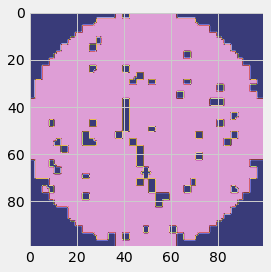

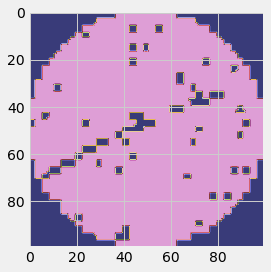

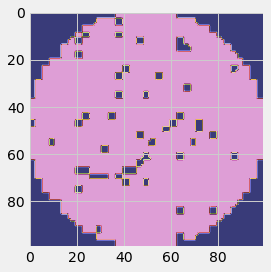

Ploting top wafers with greatest scratched dies ratio



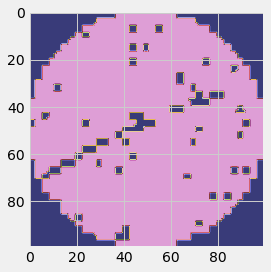

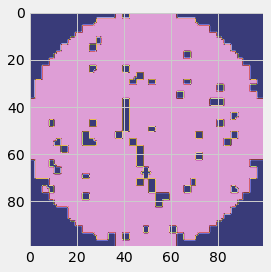

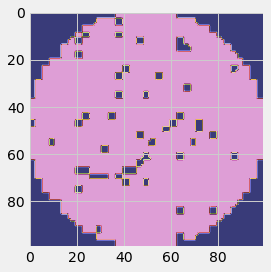

In [42]:
print("Ploting top wafers with greatest bad dies ratio\n")
curr_names=(organized_filtered_df.head())['WaferName']
train.plot_image_list(curr_names,NONESCRATCH)
print("Ploting top wafers with greatest scratched dies ratio\n")
curr_names=(organized_filtered_sc_df.head())['WaferName']
train.plot_image_list(curr_names,SCRATCH)

### **Print the top 4 wafers with gratest scratched dies ratio**

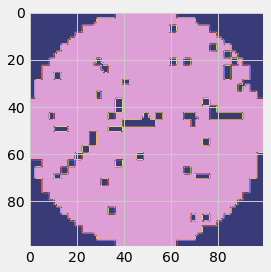

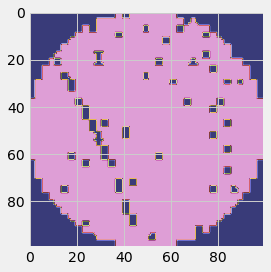

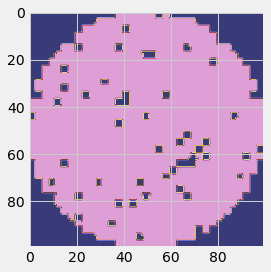

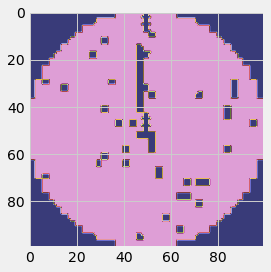

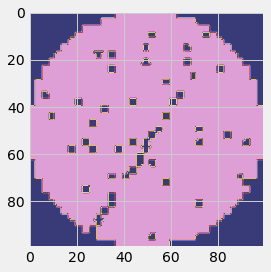

In [43]:
curr_names=(organized_filtered_test_df.head())['WaferName']
test.plot_image_list(curr_names,NONESCRATCH)

## **Preparing data for model training**

In [85]:
# Extract features and labels
X = training_data[['DieX', 'DieY', 'IsGoodDie']].values
y = training_data[['IsScratchDie']].values

# Extract testing data features
X_test = testing_data[['DieX', 'DieY', 'IsGoodDie']].values
X_test = np.asarray(X_test).astype(np.int)

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

# Reshape data for CNN input
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1]))

X_train=np.asarray(X_train).astype(np.int)
y_train=np.asarray(y_train).astype(np.int)

X_val=np.asarray(X_val).astype(np.int)
y_val=np.asarray(y_val).astype(np.int)

print("X_train ", X_train.shape)
print("X_val", X_val.shape)
print("y_train", y_train.shape)
print("y_val", y_val.shape)
print("X_test", X_test.shape)


# Normalize the data
#X_train = X_train / 255.0
#X_val = X_val / 255.0

X_train  (2412, 3)
X_val (603, 3)
y_train (2412, 1)
y_val (603, 1)
X_test (9045, 3)


## **The model**

In [45]:
# Define CNN model
model = Sequential()
input_layer = Input(shape=(X_train.shape[1]), name="Input")
flatten = Flatten()(input_layer)
Dense_layer_1 = Dense(64, activation='relu', name="Dense_1")(flatten)
Dense_layer_2 = Dense(32, activation='relu', name="Dense_2")(Dense_layer_1)
output_layer = Dense(1, activation='sigmoid', name="Output")(Dense_layer_2)
#output_layer = Dense(1, activation='softmax', name="Output")(Dense_layer_2)

# Compile and fit model
model = Model(input_layer, output_layer)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

print("X train shape",X_train.shape )
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=1000)

# Train the model using data augmentation

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 3)]               0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3)                 0         
_________________________________________________________________
Dense_1 (Dense)              (None, 64)                256       
_________________________________________________________________
Dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
Output (Dense)               (None, 1)                 33        
Total params: 2,369
Trainable params: 2,369
Non-trainable params: 0
_________________________________________________________________
X train shape (2412, 3)
Epoch 1/1000
76/76 [==============================] - 1s 4ms/step - loss: 0.0000e+00 - accuracy: 0.

## **Evaluate the model on training data**

In [46]:
scores_test = model.evaluate(X_train, y_train)
print("Test loss:", scores_test[0], "Test accuracy:", scores_test[1])
scores_val = model.evaluate(X_val, y_val)
# Need to check if for validation its still called loss
print("Validation loss:", scores_val[0], "Validation accuracy:", scores_val[1])

76/76 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.9755
Test loss: 0.0 Test accuracy: 0.975538969039917
19/19 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.9834
Validation loss: 0.0 Validation accuracy: 0.9834162592887878


## **Running model**

In [160]:
# Predict labels
y_pred = model.predict(X_test)
y_pred = np.array(y_pred)
# Create a np array to store the results
test_info_np = np.array(testing_df)

die_laybles = ['GOOD', 'GOOD_SCRATCH', 'BAD_SCRATCH', 'BAD_NOT_SCRATCH']

results_lable = []
for i in range(len(y_pred)):
    if y_pred[i] == 1: #scratched
        if test_info_np[i][3] == 1: #and is good
            results_lable.append(die_laybles[1])
        else: results_lable.append(die_laybles[2]) #scratched and is bad, need to remove
            
    else: #not scratched
        if test_info_np[i][3] == 1: #and is good
            results_lable.append(die_laybles[0])
        else: results_lable.append(die_laybles[3]) #bad because other problems 
results_lable = np.array(results_lable)

results_lable = np.expand_dims(results_lable, axis=1)

test_results = np.concatenate((test_info_np, y_pred), axis = 1)
test_results = np.concatenate((test_results, results_lable), axis = 1)

# Evaluate the model on testing data
scores_test = model.evaluate(X_test, y_pred)
print("Test loss:", scores_test[0],"Test accuracy:", scores_test[1])
# Display the final results
print(test_results)


283/283 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Test loss: 0.0 Test accuracy: 1.0
[['5a6ad6' 0 12 False 0.0 'BAD_NOT_SCRATCH']
 ['5a6ad6' 0 13 True 0.0 'GOOD']
 ['5a6ad6' 0 14 True 0.0 'GOOD']
 ...
 ['5219a1' 34 20 True 0.0 'GOOD']
 ['5219a1' 34 21 False 0.0 'BAD_NOT_SCRATCH']
 ['5219a1' 34 22 False 0.0 'BAD_NOT_SCRATCH']]
